# Validate Attention Attribution Results
This notebook contains a few functions used to validate the unexpected results encountered in the attention attribution experiments for the mBart50 model.

In [1]:
from typing import Optional
from datasets import load_from_disk
import inseq
from inseq.data.aggregator import AggregatorPipeline, SubwordAggregator
import matplotlib.pyplot as plt
import numpy as np
import torch


load datasets

In [2]:
ds = load_from_disk("../data/tatoeba_filtered")

iwslt_ds = load_from_disk("../data/iwslt_labelled")


load interpolation function

In [33]:
def create_interpolation_plot(
    attr_list: list,
    scale_size: Optional[tuple] = None,
    plt_name: Optional[str] = "interpolation_plot",
    save: bool = False,
) -> None:

    if scale_size is None:
        x = np.ceil(np.mean([attr.size(0) for attr in attr_list])).astype(int)
        y = np.ceil(np.mean([attr.size(1) for attr in attr_list])).astype(int)
        scale_size = (x, y)

    attr_list = [attr.unsqueeze(0).unsqueeze(0) for attr in attr_list]
    scaled_attr = [
        torch.nn.functional.interpolate(
            attr, size=scale_size, mode="bicubic", align_corners=True
        )
        .squeeze(0)
        .squeeze(0)
        for attr in attr_list
    ]

    scaled = torch.stack(scaled_attr).mean(dim=0)

    arr = np.flip(scaled.numpy(), axis=0)

    fig, ax = plt.subplots()

    pcm = ax.pcolormesh(arr, vmin=0, vmax=1, cmap="Reds")

    ax.set_xlabel("Generated Tokens")
    ax.set_ylabel("Attributed Tokens")

    fig.colorbar(pcm, ax=ax, shrink=0.8, label="Attention Weight")

    if save:
        plt.savefig(plt_name)


## mBart50
analyze the attention attribution on the mBart50 model

In [3]:
aggregator = AggregatorPipeline([SubwordAggregator])


In [4]:
mbart_model_de_ko = inseq.load_model(
    "facebook/mbart-large-50-many-to-many-mmt",
    "attention",
    tokenizer_kwargs={"src_lang": "de_DE", "tgt_lang": "ko_KR"},
)


In [40]:
mbart_model_ko_de = inseq.load_model(
    "facebook/mbart-large-50-many-to-many-mmt",
    "attention",
    tokenizer_kwargs={"src_lang": "ko_KR", "tgt_lang": "de_DE"},
)


In [52]:
mbart_attributions_de_ko_forced = mbart_model_de_ko.attribute(
    input_texts=ds[0:1600]["source"],
    generated_texts=ds[0:1600]["ko_nmt"],
    attribute_target=False,
    batch_size=16,
)
mbart_attributions_de_ko_forced = mbart_attributions_de_ko_forced.aggregate(
    aggregator=aggregator
)


Attributing with attention...: 100%|██████████| 36/36 [00:11<00:00,  3.12it/s]


In [53]:
mbart_attributions_de_ko_forced.sequence_attributions[0].show()

,ko_KR,"▁캐롤,",▁여기,▁Vincent이,▁있습니다.,▁말하지,▁마세요.,▁그냥,▁들어보세요.,</s>
de_DE,0.195,0.266,0.31,0.316,0.218,0.243,0.195,0.259,0.2,0.196
"▁Carol,",0.07,0.205,0.025,0.005,0.018,0.005,0.022,0.003,0.01,0.046
▁hier,0.012,0.039,0.029,0.007,0.01,0.007,0.004,0.002,0.004,0.008
▁ist,0.008,0.019,0.023,0.008,0.004,0.002,0.002,0.0,0.003,0.004
▁Vincent.,0.024,0.094,0.138,0.129,0.039,0.024,0.016,0.005,0.019,0.052
▁Sag,0.016,0.017,0.015,0.01,0.049,0.084,0.008,0.004,0.003,0.008
▁nichts.,0.012,0.022,0.025,0.009,0.038,0.057,0.01,0.004,0.003,0.007
▁Hör,0.016,0.005,0.002,0.001,0.017,0.022,0.047,0.053,0.025,0.011
▁bloß,0.014,0.007,0.001,0.002,0.019,0.024,0.043,0.071,0.011,0.012
▁zu.,0.011,0.003,0.002,0.003,0.01,0.022,0.026,0.048,0.035,0.005


In [54]:
source_attr = [
    attr.source_attributions
    for attr in mbart_attributions_de_ko_forced.sequence_attributions
]


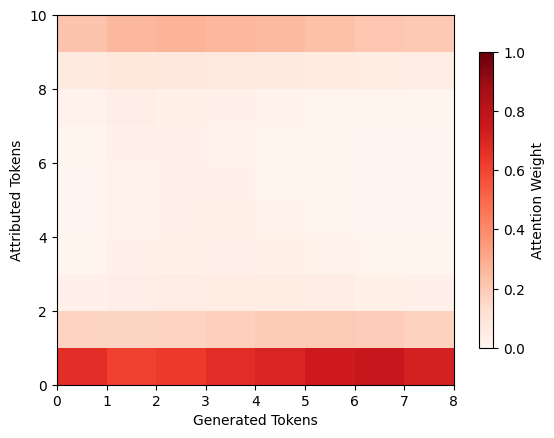

In [55]:
create_interpolation_plot(source_attr, plt_name="de_ko_forced")


In [36]:
mbart_attributions_de_ko_free = mbart_model_de_ko.attribute(
    input_texts=ds[0:160]["source"],
    generation_args={
        "forced_bos_token_id": mbart_model_de_ko.tokenizer.lang_code_to_id["ko_KR"]
    },
    attribute_target=False,
    batch_size=8,
)
mbart_attributions_de_ko_free = mbart_attributions_de_ko_free.aggregate(
    aggregator=aggregator
)


/Users/lsickert/Repositories/rude-nmt/.venv/lib/python3.10/site-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
/Users/lsickert/Repositories/rude-nmt/.venv/lib/python3.10/site-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (200) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Attributing with attention...: 100%|██████████| 56/56 [00:16<00:00,  3.36it/s]


In [37]:
source_attr = [
    attr.source_attributions
    for attr in mbart_attributions_de_ko_free.sequence_attributions
]

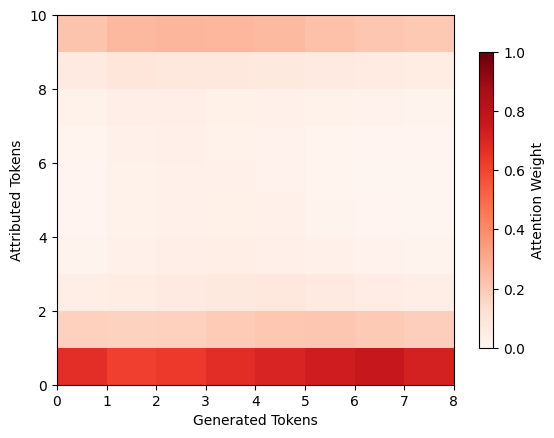

In [38]:
create_interpolation_plot(source_attr, plt_name="de_ko_free")


In [41]:
mbart_attributions_ko_de_forced = mbart_model_ko_de.attribute(
    input_texts=ds[0:160]["target"],
    generated_texts=ds[0:160]["de_nmt"],
    attribute_target=False,
    batch_size=8,
)
mbart_attributions_ko_de_forced = mbart_attributions_ko_de_forced.aggregate(
    aggregator=aggregator
)


Attributing with attention...: 100%|██████████| 62/62 [00:16<00:00,  3.77it/s]


In [42]:
mbart_attributions_ko_de_forced.sequence_attributions[0].show()

,de_DE,"▁Carol,",▁don't,▁say,"▁""Naya","▁Vincent""!",</s>
ko_KR,0.201,0.229,0.241,0.214,0.215,0.227,0.213
"▁캐럴,",0.033,0.124,0.024,0.005,0.019,0.009,0.021
▁나야,0.007,0.026,0.058,0.039,0.072,0.004,0.004
▁빈센트,0.005,0.038,0.045,0.081,0.206,0.12,0.007
▁말하지,0.007,0.011,0.024,0.047,0.012,0.013,0.01
▁말고,0.017,0.068,0.063,0.022,0.011,0.02,0.017
▁들어,0.021,0.02,0.037,0.027,0.014,0.054,0.052
</s>,0.641,0.565,0.709,0.469,0.649,0.746,0.646


In [43]:
source_attr = [
    attr.source_attributions
    for attr in mbart_attributions_ko_de_forced.sequence_attributions
]

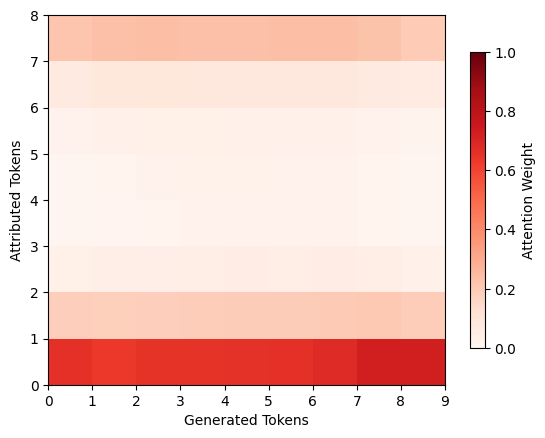

In [44]:
create_interpolation_plot(source_attr, plt_name="ko_de_forced")


In [10]:
mbart_attributions_ko_de_free = mbart_model_ko_de.attribute(
    input_texts=ds[0:16]["target"],
    generation_args={
        "forced_bos_token_id": mbart_model_de_ko.tokenizer.lang_code_to_id["de_DE"]
    },
    attribute_target=False,
    batch_size=8,
)
mbart_attributions_ko_de_free = mbart_attributions_ko_de_free.aggregate(
    aggregator=aggregator
)
mbart_attributions_ko_de_free.show()


Attributing with attention...: 100%|██████████| 14/14 [00:02<00:00,  4.46it/s]


,de_DE,"▁""Come,",▁baby.,▁Du,▁bist,▁nicht,"▁allein.""",</s>
ko_KR,0.21,0.261,0.313,0.218,0.185,0.202,0.193,0.193
▁가자,0.021,0.057,0.009,0.005,0.002,0.001,0.002,0.006
▁아가야,0.014,0.081,0.102,0.009,0.003,0.005,0.006,0.01
▁넌,0.011,0.01,0.022,0.033,0.008,0.007,0.009,0.007
▁혼자가,0.009,0.015,0.017,0.027,0.03,0.026,0.036,0.007
▁아냐,0.016,0.014,0.015,0.026,0.004,0.007,0.014,0.008
</s>,0.67,0.776,0.665,0.648,0.755,0.73,0.779,0.745


In [ ]:
mbart_model_de_en = inseq.load_model(
    "facebook/mbart-large-50-many-to-many-mmt",
    "attention",
    tokenizer_kwargs={"src_lang": "de_DE", "tgt_lang": "en_XX"},
)


In [ ]:
mbart_model_en_de = inseq.load_model(
    "facebook/mbart-large-50-many-to-many-mmt",
    "attention",
    tokenizer_kwargs={"src_lang": "en_XX", "tgt_lang": "de_DE"},
)


In [ ]:
nllb_model = inseq.load_model(
    "facebook/nllb-200-distilled-600M",
    "attention",
    tokenizer_kwargs={"src_lang": "deu_Latn", "tgt_lang": "kor_Hang"},
)


In [ ]:
out = nllb_model.attribute(
    input_texts=ds[0:16]["source"],
    generation_args={
        "forced_bos_token_id": nllb_model.tokenizer.lang_code_to_id["kor_Hang"]
    },
    attribute_target=False,
    batch_size=8,
)
out.show()


In [ ]:
# "Helsinki-NLP/opus-mt-en-de"
opus_model = inseq.load_model("Helsinki-NLP/opus-mt-de-en", "attention")


In [ ]:
out = opus_model.attribute(
    input_texts=ds[0:16]["source"], attribute_target=False, batch_size=8
)
out.show()
